In [29]:
import sys
sys.path.append('../../..')

In [33]:
import pandas as pd
import os
from num2words import num2words
from utils.deepmatcher_utils import wrapDm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import numpy as np

In [3]:
DATA_DIR = '../../../datasets/Structured/itunes-amazon/'
train_df = pd.read_csv(DATA_DIR+'merged_train.csv')
validation_df = pd.read_csv(DATA_DIR+'merged_valid.csv')
test_df = pd.read_csv(DATA_DIR+'merged_test.csv')

In [21]:
def convert_time_towords(time):
    parts = time.split(':')
    if len(parts) <= 1:
        return time
    minutes = num2words(parts[0])
    seconds = num2words(parts[1])
    return minutes+" minutes and " +seconds+" seconds" 

In [7]:
def convert_price_towords(price):
    if price == 'Album Only':
        return price
    parts = price.split()
    price = num2words(parts[1])
    return parts[0]+ " "+price

In [8]:
convert_time_towords('3:15')

'three minutes and fifteen seconds'

In [9]:
convert_time_towords('4:40')

'four minutes and forty seconds'

In [10]:
convert_price_towords(train_df['ltable_Price'].iloc[0])

'$ one point two nine'

In [11]:
convert_price_towords('Album Only')

'Album Only'

In [12]:
train_df['ltable_Price'] = train_df['ltable_Price'].apply(convert_price_towords)
train_df['rtable_Price'] = train_df['rtable_Price'].apply(convert_price_towords)

In [13]:
validation_df['ltable_Price'] = validation_df['ltable_Price'].apply(convert_price_towords)
validation_df['rtable_Price'] = validation_df['rtable_Price'].apply(convert_price_towords)

In [14]:
test_df['ltable_Price'] = test_df['ltable_Price'].apply(convert_price_towords)
test_df['rtable_Price'] = test_df['rtable_Price'].apply(convert_price_towords)

In [15]:
train_df.head()

,label,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id
0,0,Illusion ( feat . Echosmith ),Zedd,True Colors,"Dance , Music , Electronic",$ one point two nine,2015 Interscope Records,6:30,18-May-15,Transmission [ feat . X Ambassadors ],Zedd,True Colors,Dance & Electronic,$ one point two nine,( C ) 2015 Interscope Records,4:02,"May 18 , 2015",245
1,0,I 'm a Machine ( feat . Crystal Nicole and Tyr...,David Guetta,Nothing But the Beat,"Dance , Music , Rock , House , Electronic",$ one point two nine,"2011 What A Music Ltd , Licence exclusive Parl...",3:34,26-Aug-11,I Can Only Imagine ( feat . Chris Brown & Lil ...,David Guetta,Nothing But the Beat 2.0 [ Explicit ],Dance & Electronic,$ zero point nine nine,2015 Real Sounds,3:29,"August 26 , 2011",44
2,0,I 'm a Machine ( feat . Crystal Nicole and Tyr...,David Guetta,Nothing But the Beat,"Dance , Music , House , Electronic , Rock",$ one point two nine,"2011 What A Music Ltd , Licence exclusive Parl...",3:34,26-Aug-11,I Can Only Imagine ( feat . Chris Brown & Lil ...,David Guetta,Nothing But the Beat 2.0 [ Explicit ],Dance & Electronic,$ zero point nine nine,2015 Real Sounds,3:29,"August 26 , 2011",58
3,1,Silver and Gold,Little Big Town,Pain Killer,"Country , Music , Honky Tonk , Contemporary Co...",$ one point two nine,"2014 Little Big Town , LLC Under exclusive lic...",3:33,21-Oct-14,Silver And Gold,Little Big Town,Pain Killer,Country,$ one point two nine,( C ) 2014 Little Big Town LLC Under exclusive...,3:31,"October 21 , 2014",102
4,0,Dangerous ( feat . Sam Martin ) [ Robin Schulz...,David Guetta,Listen ( Deluxe Version ),"Dance , Music , Rock , House , Electronic , Fr...",$ one point two nine,2014 What A Music Ltd. under exclusive license...,3:20,24-Nov-14,I 'll Keep Loving you ( feat . Birdy & Jaymes ...,David Guetta,Listen ( Deluxe ),Dance & Electronic,$ one point two nine,2015 If Moving Your Mine,3:08,"November 24 , 2014",50


In [16]:
train_df['ltable_Time'] = train_df['ltable_Time'].apply(convert_time_towords)
train_df['rtable_Time'] = train_df['rtable_Time'].apply(convert_time_towords)

In [17]:
validation_df['ltable_Time'] = validation_df['ltable_Time'].apply(convert_time_towords)
validation_df['rtable_Time'] = validation_df['rtable_Time'].apply(convert_time_towords)

In [18]:
test_df['ltable_Time'] = test_df['ltable_Time'].apply(convert_time_towords)
test_df['rtable_Time'] = test_df['rtable_Time'].apply(convert_time_towords)

In [19]:
test_df.head()

,label,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id
0,0,Elevator ( feat . Timbaland ),Flo Rida,Mail On Sunday ( Deluxe Version ),"Hip-Hop/Rap , Music , Dirty South",$ one point nine nine,2008 Atlantic Recording Corporation for the Un...,three minutes and fifty-five seconds,17-Mar-08,Money Right ( feat . Rick Ross & Brisco ) [ Ex...,Flo Rida,Mail On Sunday [ Explicit ],Rap & Hip-Hop,$ one point two nine,2013 Warner Bros. . Records Inc.,three minutes and seventeen seconds,"March 17 , 2008",731
1,0,The Woodland Realm ( Extended Version ),Howard Shore,The Hobbit : The Desolation of Smaug ( Origina...,"Soundtrack , Music , Soundtrack , Classical , ...",$ one point two nine,‰ ãÑ 2013 WaterTower Music,five minutes and fourteen seconds,10-Dec-13,The High Fells ( Extended Version ),Howard Shore,The Hobbit : The Desolation of Smaug ( Origina...,Soundtracks,$ one point two nine,2013 WaterTower Music / Warner Bros. . Enterta...,three minutes and thirty-eight seconds,"December 10 , 2013",672
2,1,Extra Extra Credit,Wiz Khalifa,Flight School,"Hip-Hop/Rap , Music",$ zero point nine nine,2009 Rostrum Records,four minutes and three seconds,17-Apr-09,Extra Extra Credit [ Explicit ],Wiz Khalifa,Flight School [ Explicit ],Rap & Hip-Hop,$ zero point nine nine,2013 Mad Decent,four minutes and three seconds,"April 17 , 2009",669
3,0,Toyfriend ( feat . Wynter Gordon ) [ Continuou...,David Guetta,One Love ( Deluxe Version ),"Dance , Music",$ one point two nine,2010 Gum Prod licence exclusive Parlophone Mus...,two minutes and fifty-one seconds,21-Aug-09,Sound Of Letting Go ( Feat . Chris Willis ),David Guetta,One Love ( Deluxe Version ),Dance & Electronic,$ one point two nine,( C ) 2014 Swedish House Mafia Holdings Ltd ( ...,three minutes and forty-seven seconds,"August 21 , 2009",734
4,0,Dangerous ( feat . Sam Martin ) [ Robin Schulz...,David Guetta,Listen ( Deluxe Version ),"Dance , Music , Rock , House , Electronic , Fr...",$ one point two nine,2014 What A Music Ltd. under exclusive license...,three minutes and twenty seconds,24-Nov-14,Missing You ( Feat . Novel ; Continuous Mix Ve...,David Guetta,One Love ( Deluxe Version ),Dance & Electronic,$ one point two nine,( C ) 2014 Swedish House Mafia Holdings Ltd ( ...,four minutes and fifty-nine seconds,"August 21 , 2009",699


In [23]:
if not(os.path.exists('exp5')):
    os.mkdir('exp5')

In [24]:
train_df.to_csv('exp5/train_naturalencoding.csv',index=False)
validation_df.to_csv('exp5/validation_naturalencoding.csv',index=False)
test_df.to_csv('exp5/test_naturalencoding.csv',index=False)

### Create Positive and negative examples

In [51]:
train_negatives = train_df[train_df['label']==0]
validation_negatives = validation_df[validation_df['label']==0]
test_negatives = test_df[test_df['label']==0]

In [52]:
train_positives = train_df[train_df['label']==1]
validation_positives = validation_df[validation_df['label']==1]
test_positives = test_df[test_df['label']==1]

In [53]:
negatives_df = train_negatives.append(validation_negatives,ignore_index=True)
negatives_df = negatives_df.append(test_negatives,ignore_index=True)

In [54]:
positives_df = train_positives.append(validation_positives,ignore_index=True)
positives_df = positives_df.append(test_positives,ignore_index=True)

In [55]:
negatives_df.shape, positives_df.shape

((407, 18), (132, 18))

In [58]:
negatives_df.to_csv('sample_data/itunes-amazon/exp5/negatives_naturalencoding.csv',index=False)
positives_df.to_csv('sample_data/itunes-amazon/exp5/positives_naturalencoding.csv',index=False)

## Training with new datasets

In [25]:
import deepmatcher as dm 
data_dir = 'exp5'
train,validation,test = dm.data.process(path = data_dir,train='train_naturalencoding.csv',validation
                                        ='validation_naturalencoding.csv',test='test_naturalencoding.csv'
                                        ,left_prefix='ltable_',right_prefix='rtable_',cache = 'naturalencoding.pth')


Reading and processing data from "exp5/train_naturalencoding.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "exp5/validation_naturalencoding.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "exp5/test_naturalencoding.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [26]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')

In [27]:
hybrid_model.run_train(train,validation,best_save_path='../../../models/hybrid_natencoding.pth',
                       epochs=20,
                      batch_size=16,
                      pos_neg_ratio=4)

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 1 || Run Time:   10.2 | Load Time:    2.1 || F1:  47.89 | Prec:  33.01 | Rec:  87.18 || Ex/s:  26.25

===>  EVAL Epoch 1


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 1 || Run Time:    1.2 | Load Time:    0.6 || F1:  57.14 | Prec:  46.51 | Rec:  74.07 || Ex/s:  59.66

* Best F1: tensor(57.1429, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Finished Epoch 2 || Run Time:   10.3 | Load Time:    2.1 || F1:  70.83 | Prec:  59.65 | Rec:  87.18 || Ex/s:  25.86

===>  EVAL Epoch 2


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 2 || Run Time:    1.3 | Load Time:    0.6 || F1:  62.16 | Prec:  48.94 | Rec:  85.19 || Ex/s:  55.83

* Best F1: tensor(62.1622, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 3 || Run Time:    9.7 | Load Time:    1.9 || F1:  76.84 | Prec:  65.18 | Rec:  93.59 || Ex/s:  27.47

===>  EVAL Epoch 3


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 3 || Run Time:    1.0 | Load Time:    0.5 || F1:  78.12 | Prec:  67.57 | Rec:  92.59 || Ex/s:  69.09

* Best F1: tensor(78.1250, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 4 || Run Time:    9.0 | Load Time:    1.7 || F1:  83.98 | Prec:  73.79 | Rec:  97.44 || Ex/s:  29.96

===>  EVAL Epoch 4


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 4 || Run Time:    0.9 | Load Time:    0.5 || F1:  74.07 | Prec:  74.07 | Rec:  74.07 || Ex/s:  78.33

---------------------

===>  TRAIN Epoch 5


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 5 || Run Time:    8.0 | Load Time:    1.5 || F1:  92.68 | Prec:  88.37 | Rec:  97.44 || Ex/s:  33.75

===>  EVAL Epoch 5


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 5 || Run Time:    0.9 | Load Time:    0.5 || F1:  80.70 | Prec:  76.67 | Rec:  85.19 || Ex/s:  77.68

* Best F1: tensor(80.7018, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 6 || Run Time:    7.8 | Load Time:    1.6 || F1:  96.30 | Prec:  92.86 | Rec: 100.00 || Ex/s:  34.00

===>  EVAL Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 6 || Run Time:    0.9 | Load Time:    0.5 || F1:  82.35 | Prec:  87.50 | Rec:  77.78 || Ex/s:  79.23

* Best F1: tensor(82.3529, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 7 || Run Time:    8.2 | Load Time:    1.6 || F1:  96.30 | Prec:  92.86 | Rec: 100.00 || Ex/s:  32.71

===>  EVAL Epoch 7


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 7 || Run Time:    0.9 | Load Time:    0.5 || F1:  86.27 | Prec:  91.67 | Rec:  81.48 || Ex/s:  78.42

* Best F1: tensor(86.2745, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 8 || Run Time:    8.2 | Load Time:    1.6 || F1:  97.50 | Prec:  95.12 | Rec: 100.00 || Ex/s:  32.86

===>  EVAL Epoch 8


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 8 || Run Time:    0.9 | Load Time:    0.5 || F1:  85.25 | Prec:  76.47 | Rec:  96.30 || Ex/s:  78.62

---------------------

===>  TRAIN Epoch 9


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 9 || Run Time:    8.9 | Load Time:    1.7 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  30.13

===>  EVAL Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 9 || Run Time:    0.9 | Load Time:    0.5 || F1:  85.25 | Prec:  76.47 | Rec:  96.30 || Ex/s:  79.03

---------------------

===>  TRAIN Epoch 10


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 10 || Run Time:    7.6 | Load Time:    1.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  35.16

===>  EVAL Epoch 10


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 10 || Run Time:    0.9 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  79.59

---------------------

===>  TRAIN Epoch 11


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 11 || Run Time:    7.9 | Load Time:    1.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  34.24

===>  EVAL Epoch 11


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    1.0 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  70.15

---------------------

===>  TRAIN Epoch 12


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 12 || Run Time:    7.7 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  34.46

===>  EVAL Epoch 12


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 12 || Run Time:    1.0 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  69.21

---------------------

===>  TRAIN Epoch 13


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 13 || Run Time:    7.4 | Load Time:    1.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  36.10

===>  EVAL Epoch 13


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 13 || Run Time:    0.9 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  78.96

---------------------

===>  TRAIN Epoch 14


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 14 || Run Time:    7.9 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  33.96

===>  EVAL Epoch 14


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 14 || Run Time:    0.9 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  79.68

---------------------

===>  TRAIN Epoch 15


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 15 || Run Time:    8.0 | Load Time:    1.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  33.79

===>  EVAL Epoch 15


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 15 || Run Time:    0.9 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  79.49

---------------------

===>  TRAIN Epoch 16


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 16 || Run Time:    7.9 | Load Time:    1.5 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  33.96

===>  EVAL Epoch 16


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 16 || Run Time:    0.9 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  78.72

---------------------

===>  TRAIN Epoch 17


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 17 || Run Time:    9.1 | Load Time:    1.7 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.71

===>  EVAL Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 17 || Run Time:    1.0 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  69.96

---------------------

===>  TRAIN Epoch 18


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 18 || Run Time:    9.5 | Load Time:    1.8 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.35

===>  EVAL Epoch 18


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 18 || Run Time:    1.0 | Load Time:    0.6 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  68.78

---------------------

===>  TRAIN Epoch 19


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 19 || Run Time:    9.6 | Load Time:    1.8 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.21

===>  EVAL Epoch 19


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 19 || Run Time:    1.0 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  70.39

---------------------

===>  TRAIN Epoch 20


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 20 || Run Time:    9.9 | Load Time:    1.9 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.09

===>  EVAL Epoch 20


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 20 || Run Time:    1.0 | Load Time:    0.5 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  69.98

---------------------

Loading best model...
Training done.


tensor(86.2745, device='cuda:0')

In [28]:
hybrid_model.run_eval(test)

===>  EVAL Epoch 7
Finished Epoch 7 || Run Time:    0.6 | Load Time:    0.6 || F1:  94.34 | Prec:  96.15 | Rec:  92.59 || Ex/s:  87.73



tensor(94.3396, device='cuda:0')

## Test bias

In [38]:
test_neg = test_df[test_df.label==0].copy()
test_pos = test_df[test_df.label==1].copy()

In [39]:
test_neg.to_csv('exp5/test_negatives.csv',index=False)
test_pos.to_csv('exp5/test_positives.csv',index=False)

In [ ]:
test_df['ltable_Time'] = test_df['rtable_Time']

In [35]:
predictions = wrapDm(test_neg,hybrid_model)
np.count_nonzero(np.argmax(predictions,axis=1)==0)

79

## Compute Ri

In [36]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [40]:
testneg = return_layer_input(hybrid_model,hybrid_model.classifier,'exp5',
                            'test_negatives',0)
testpos = return_layer_input(hybrid_model,hybrid_model.classifier,'exp5',
                            'test_positives',1)

In [46]:
testneg_ri,testneg_ri_agg = computeRi(hybrid_model.classifier,attributes,testneg,
                                     0,'cosine')

100%|██████████| 81/81 [00:28<00:00,  2.80it/s]


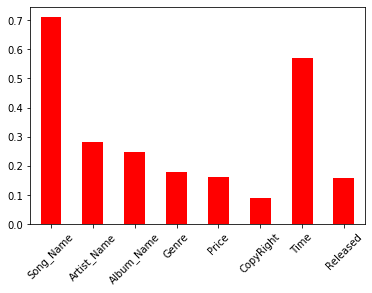

In [51]:
testneg_ri_agg.drop(['sample_id'],axis=1).mean().plot.bar(color='red',rot=45)

In [49]:
testpos_ri,testpos_ri_agg = computeRi(hybrid_model.classifier,attributes,testpos,
                                     1,'cosine')

100%|██████████| 25/25 [00:05<00:00,  4.32it/s]


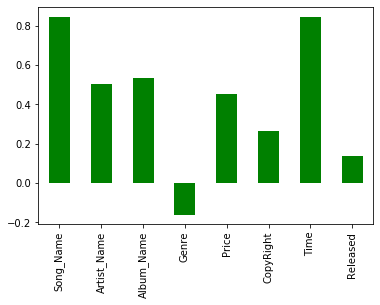

In [50]:
testpos_ri_agg.drop(['sample_id'],axis=1).mean().plot.bar(color='green')